# Predictions for Binance Coin

In [1]:
import yfinance as yf
import ta
from sklearn.ensemble import RandomForestRegressor
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.models import  NaiveDrift, NaiveSeasonal, TCNModel, BlockRNNModel, TransformerModel, TFTModel
import matplotlib.pyplot as plt
import numpy as np
import torch
import plotly.graph_objects as go
from darts.metrics import mae, rmse, mse, mape
from pytorch_lightning.callbacks import EarlyStopping 




torch.manual_seed(1)
np.random.seed(1)



c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\utils.py:236: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph(actual, prediction, print_single, model):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = "Binance Coin prices")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [3]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph_backtesting(actual, prediction, print_single, model, horizon):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = f"Backtesting for Binance Coin prices with Forecasting Horizon = {horizon}")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [4]:
#retrieve binance coin data
start_date = '2014-09-17'
end_date = '2024-01-23'

df = yf.download('BNB-USD', interval = '1d', start = start_date, end = end_date)
df = df.drop('Adj Close', axis=1)
df = ta.utils.dropna(df)
df = ta.add_all_ta_features(
    df, "Open", "High", "Low", "Close", "Volume", fillna=True
)
df = df.fillna(0)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [5]:
df

Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09    2.053140    2.174230    1.893940    1.990770    19192200   
2017-11-10    2.007730    2.069470    1.644780    1.796840    11155000   
2017-11-11    1.786280    1.917750    1.614290    1.670470     8178150   
2017-11-12    1.668890    1.672800    1.462560    1.519690    15298700   
2017-11-13    1.526010    1.735020    1.517600    1.686620    12238800   
...                ...         ...         ...         ...         ...   
2024-01-18  309.093109  315.143188  305.717163  313.292877  1105813150   
2024-01-19  313.292877  315.640076  306.377838  314.300446  1036123822   
2024-01-20  314.300232  316.960388  312.303619  316.960388   694855739   
2024-01-21  316.961761  321.283813  316.222595  318.318695   723174009   
2024-01-22  318.379089  319.740082  304.578217  305.437012   948987847   

              volume_adi    volume_obv  volume_cmf     volume_fi  volume_em  \
Date                                                                          
2017-11-09 -5.931791e+06      19192200   -0.309073  0.000000e+00   0.000000   
2017-11-10 -9.098711e+06       8037200   -0.299820 -2.163289e+06  -0.673717   
2017-11-11 -1.424879e+07       -140950   -0.369855 -2.001887e+06  -0.338056   
2017-11-12 -2.123305e+07     -15439650   -0.394490 -2.045437e+06  -0.272566   
2017-11-13 -1.444322e+07      -3200850   -0.218629 -1.461371e+06   0.104155   
...                  ...           ...         ...           ...        ...   
2024-01-18  1.873457e+11  118175806077    0.041607  2.066371e+09  -1.033954   
2024-01-19  1.880821e+11  119211929899    0.069023  1.920313e+09   0.517391   
2024-01-20  1.887770e+11  119906785638    0.131167  1.910022e+09   2.428086   
2024-01-21  1.886528e+11  120629959647    0.100953  1.777489e+09   2.884271   
2024-01-22  1.878114e+11  119680971800    0.084845 -2.228034e+08 -10.535243   

            ...  momentum_ppo  momentum_ppo_signal  momentum_ppo_hist  \
Date        ...                                                         
2017-11-09  ...      0.000000             0.000000           0.000000   
2017-11-10  ...     -0.782745            -0.156549          -0.626196   
2017-11-11  ...     -1.919148            -0.509069          -1.410080   
2017-11-12  ...     -3.452974            -1.097850          -2.355124   
2017-11-13  ...     -3.932817            -1.664843          -2.267974   
...         ...           ...                  ...                ...   
2024-01-18  ...      2.685874             3.324096          -0.638222   
2024-01-19  ...      2.637229             3.186723          -0.549494   
2024-01-20  ...      2.636603             3.076699          -0.440096   
2024-01-21  ...      2.639564             2.989272          -0.349708   
2024-01-22  ...      2.280337             2.847485          -0.567148   

            momentum_pvo  momentum_pvo_signal  momentum_pvo_hist  \
Date                                                               
2017-11-09      0.000000             0.000000           0.000000   
2017-11-10     -3.447595            -0.689519          -2.758076   
2017-11-11     -7.706147            -2.092845          -5.613302   
2017-11-12     -7.732396            -3.220755          -4.511641   
2017-11-13     -9.193153            -4.415235          -4.777919   
...                  ...                  ...                ...   
2024-01-18      1.132294             2.182050          -1.049756   
2024-01-19      0.113461             1.768332          -1.654871   
2024-01-20     -3.153055             0.784055          -3.937110   
2024-01-21     -5.623311            -0.497418          -5.125893   
2024-01-22     -5.826163            -1.563167          -4.262996   

            momentum_kama  others_dr  others_dlr     others_cr  
Date                                                            
2017-11-09       1.990770   0.000000    0.000000      0.000000

# Feature engineering

In [6]:

split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing
X_train = df.iloc[:split_index].drop('Close', axis=1)
y_train = df.iloc[:split_index]['Close']
X_test = df.iloc[split_index:].drop('Close', axis=1)
y_test = df.iloc[split_index:]['Close']

In [7]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [8]:
clf.score(X_test, y_test)

0.9982992088965605

In [9]:
features = {k: v for k, v in sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)}

In [10]:
features

{'others_cr': 0.41355271981758573,
 'Low': 0.20876153443613119,
 'volatility_bbh': 0.04347834497020584,
 'High': 0.03527169688322492,
 'Open': 0.034934010647466276,
 'trend_ichimoku_conv': 0.02638415044606444,
 'trend_ichimoku_b': 0.026173384849973638,
 'trend_sma_slow': 0.026081272246753006,
 'momentum_kama': 0.017622038842429646,
 'volatility_kch': 0.017562095019156787,
 'volatility_kcc': 0.01751208319545329,
 'trend_ichimoku_a': 0.01746889620485392,
 'volume_vwap': 0.01745554592250614,
 'trend_ema_fast': 0.01737701828118353,
 'volatility_bbm': 0.008928388383818526,
 'volume_adi': 0.00890233213102279,
 'trend_ichimoku_base': 0.008891072937381214,
 'trend_psar_up': 0.008883899676959123,
 'trend_ema_slow': 0.008825493935603135,
 'trend_sma_fast': 0.008761691137256456,
 'volume_obv': 0.008757882240490565,
 'volatility_dcm': 0.008675586126609059,
 'volatility_dcl': 0.008667367349093917,
 'volume_vpt': 0.0003795151229309119,
 'volatility_dch': 0.0001239243996123606,
 'trend_dpo': 0.000107

In [11]:
filtered_features = {feature: importance for feature, importance in features.items() if importance >= 0.01}


In [12]:
filtered_features

{'others_cr': 0.41355271981758573,
 'Low': 0.20876153443613119,
 'volatility_bbh': 0.04347834497020584,
 'High': 0.03527169688322492,
 'Open': 0.034934010647466276,
 'trend_ichimoku_conv': 0.02638415044606444,
 'trend_ichimoku_b': 0.026173384849973638,
 'trend_sma_slow': 0.026081272246753006,
 'momentum_kama': 0.017622038842429646,
 'volatility_kch': 0.017562095019156787,
 'volatility_kcc': 0.01751208319545329,
 'trend_ichimoku_a': 0.01746889620485392,
 'volume_vwap': 0.01745554592250614,
 'trend_ema_fast': 0.01737701828118353}

In [13]:
filtered_feature_names = list(filtered_features.keys())
df = df.reset_index()
covs= TimeSeries.from_dataframe(df, time_col="Date", value_cols=filtered_feature_names)
covs = covs.astype(np.float32)
target = TimeSeries.from_dataframe(df, time_col="Date", value_cols=["Close"])
target = target.astype(np.float32)

# Create Train, Validation and Test Set + Past and Future Covariates

In [14]:
#create train and validation series and scale them
val_set_size = 28

test_set_size = 365

train_target = target[: -(val_set_size + test_set_size)]

val_target = target[-(val_set_size + test_set_size) : -test_set_size]

test_target = target[-(test_set_size) :]

scaler_target = Scaler()
scaler_features = Scaler()

scaler_target = scaler_target.fit(train_target)


train_scaled = scaler_target.transform(train_target)
val_scaled = scaler_target.transform(val_target)
test_scaled = scaler_target.transform(test_target)

target_scaled = concatenate([train_scaled, val_scaled, test_scaled])


Number of components is larger than 10 (14). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


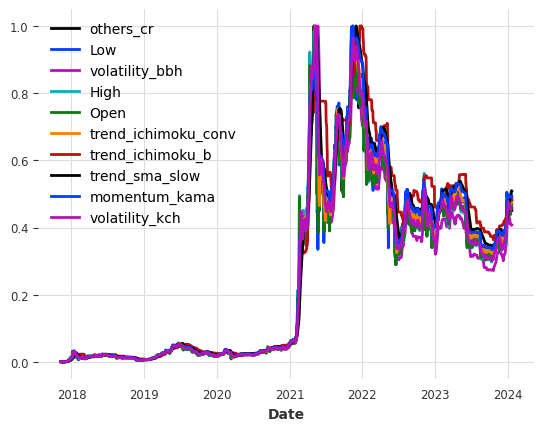

In [15]:
past_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
        covs,
    ],
    axis="component",
)


scaler_ft_past = Scaler()

past_covs = scaler_ft_past.fit_transform(past_covs)
idx = past_covs.columns[6:]
tech_analysis_idx = past_covs[idx.to_list()]
tech_analysis_idx.plot()
plt.show()

In [16]:
future_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
    ],
    axis="component",
)


scaler_ft_future = Scaler()


future_covs = scaler_ft_future.fit_transform(future_covs)

In [17]:
val = scaler_target.inverse_transform(val_scaled)

test = scaler_target.inverse_transform(test_scaled)

# Create csv file where to store all of the Error Metrics

In [18]:
import csv

headers = ['Model', 'MAE', 'RMSE', 'MSE', 'MAPE']
separator = ['-', '-', '-', '-', '-']

with open('./results/error_metrics_BNB.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(headers)

def add_row(row):
  with open('./results/error_metrics_BNB.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(row)

# Naive Models

In [19]:
models = {}
predictions = {}

models['naive_drift_model'] = NaiveDrift()
models['naive_model'] = NaiveSeasonal()
models['naive_seasonal_model'] = NaiveSeasonal(7)


for key, model in models.items():
    model.fit(train_scaled)
    predictions[key] = model.predict(len(val_scaled))
    predictions[key] = scaler_target.inverse_transform(predictions[key])

In [20]:
print_graph(val, predictions, False, None)

In [21]:
for key, prediction in predictions.items():
    print(f"MAE of {key}: {mae(val, prediction)}")
    print(f"RMSE of {key}: {rmse(val, prediction)}")
    print(f"MSE of {key}: {mse(val, prediction)}")
    print(f"MAPE of {key}: {mape(val, prediction)}")
    print("\n")
    row = [f'{key}', mae(val, prediction), rmse(val, prediction), mse(val, prediction), mape(val, prediction) ]
    add_row(row)

add_row(separator)

MAE of naive_drift_model: 27.57174301147461
RMSE of naive_drift_model: 35.363380432128906
MSE of naive_drift_model: 1250.568603515625
MAPE of naive_drift_model: 9.495620429515839


MAE of naive_model: 29.439632415771484
RMSE of naive_model: 37.43840789794922
MSE of naive_model: 1401.634521484375
MAPE of naive_model: 10.154842585325241


MAE of naive_seasonal_model: 28.045608520507812
RMSE of naive_seasonal_model: 35.86454391479492
MSE of naive_seasonal_model: 1286.265625
MAPE of naive_seasonal_model: 9.67036634683609




# Backtesting Naive Drift Model

In [22]:
bt_horizons = [1, 7 ,30]
bt_start=test_target.time_index[0]


In [23]:
backtesting_Drift = []
backtesting_Naive = []
backtesting_NaiveSeasonal = []
backtesting_ExpSmoothing = []
backtesting_Arima = []
backtesting_Prophet = []
backtesting_Tbats = []

In [24]:

for h in bt_horizons:
  hist_Drift = models['naive_drift_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Drift = scaler_target.inverse_transform(hist_Drift)
  backtesting_Drift.append(hist_predict_Drift)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [25]:
len(backtesting_Drift)

3

In [26]:
for b in backtesting_Drift:
  h = bt_horizons[backtesting_Drift.index(b)]
  print_graph_backtesting(test, b, True, 'naive_drift_model',h)

In [27]:
add_row(['Backtesting Naive Drift Model','','','',''])
for b in backtesting_Drift:
  print(f"MAE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Drift fh={bt_horizons[backtesting_Drift.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Drift Model forecasting horizon = 1: 4.328587055206299
RMSE of Naive Drift Model forecasting horizon = 1: 6.506417274475098
MSE of Naive Drift Model forecasting horizon = 1: 42.333465576171875
MAPE of Naive Drift Model forecasting horizon = 1: 1.5816226601600647


MAE of Naive Drift Model forecasting horizon = 7: 11.615285873413086
RMSE of Naive Drift Model forecasting horizon = 7: 16.59286117553711
MSE of Naive Drift Model forecasting horizon = 7: 275.3230285644531
MAPE of Naive Drift Model forecasting horizon = 7: 4.280217736959457


MAE of Naive Drift Model forecasting horizon = 30: 25.07498550415039
RMSE of Naive Drift Model forecasting horizon = 30: 34.384552001953125
MSE of Naive Drift Model forecasting horizon = 30: 1182.2974853515625
MAPE of Naive Drift Model forecasting horizon = 30: 9.529222548007965




# Backtesting Naive Model

In [28]:
for h in bt_horizons:
  hist_Naive = models['naive_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Naive = scaler_target.inverse_transform(hist_Naive)
  backtesting_Naive.append(hist_predict_Naive)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [29]:
for b in backtesting_Naive:
  h = bt_horizons[backtesting_Naive.index(b)]
  print_graph_backtesting(test, b, True, 'naive_model',h)

In [30]:
add_row(['Backtesting Naive Model','','','',''])
for b in backtesting_Naive:
  print(f"MAE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive fh={bt_horizons[backtesting_Naive.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Model forecasting horizon = 1: 4.333034038543701
RMSE of Naive Model forecasting horizon = 1: 6.503357410430908
MSE of Naive Model forecasting horizon = 1: 42.29365539550781
MAPE of Naive Model forecasting horizon = 1: 1.5829917043447495


MAE of Naive Model forecasting horizon = 7: 11.470878601074219
RMSE of Naive Model forecasting horizon = 7: 16.54231834411621
MSE of Naive Model forecasting horizon = 7: 273.6483154296875
MAPE of Naive Model forecasting horizon = 7: 4.223451018333435


MAE of Naive Model forecasting horizon = 30: 24.55708885192871
RMSE of Naive Model forecasting horizon = 30: 33.788211822509766
MSE of Naive Model forecasting horizon = 30: 1141.643310546875
MAPE of Naive Model forecasting horizon = 30: 9.241335839033127




# Backtesting Naive Seasonal Model

In [31]:
for h in bt_horizons:
  hist_NaiveSeasonal = models['naive_seasonal_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_NaiveSeasonal = scaler_target.inverse_transform(hist_NaiveSeasonal)
  backtesting_NaiveSeasonal.append(hist_predict_NaiveSeasonal)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [32]:
for b in backtesting_NaiveSeasonal:
  h = bt_horizons[backtesting_NaiveSeasonal.index(b)]
  print_graph_backtesting(test, b, True, 'naive_seasonal_model',h)

In [33]:
add_row(['Backtesting Naive Seasonal Model','','','',''])
for b in backtesting_NaiveSeasonal:
  print(f"MAE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Seasonal fh={bt_horizons[backtesting_NaiveSeasonal.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Seasonal Model forecasting horizon = 1: 11.413156509399414
RMSE of Naive Seasonal Model forecasting horizon = 1: 16.4570369720459
MSE of Naive Seasonal Model forecasting horizon = 1: 270.83404541015625
MAPE of Naive Seasonal Model forecasting horizon = 1: 4.196736216545105


MAE of Naive Seasonal Model forecasting horizon = 7: 11.470878601074219
RMSE of Naive Seasonal Model forecasting horizon = 7: 16.54231834411621
MSE of Naive Seasonal Model forecasting horizon = 7: 273.6483154296875
MAPE of Naive Seasonal Model forecasting horizon = 7: 4.223451018333435


MAE of Naive Seasonal Model forecasting horizon = 30: 26.3051700592041
RMSE of Naive Seasonal Model forecasting horizon = 30: 36.35243225097656
MSE of Naive Seasonal Model forecasting horizon = 30: 1321.4993896484375
MAPE of Naive Seasonal Model forecasting horizon = 30: 9.942656755447388




# Graphs of the Naive Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [49]:
predictions_naive_1= {}
predictions_naive_7= {}
predictions_naive_30= {}

naive_models = ['Naive', 'Naive Drift', 'Naive Seasonal']
backtesting_naive =[backtesting_Naive, backtesting_Drift, backtesting_NaiveSeasonal]
predictions_naive = [predictions_naive_1, predictions_naive_7, predictions_naive_30]

for i in predictions_naive:
    for j in naive_models:
        i[j] = backtesting_naive[naive_models.index(j)][predictions_naive.index(i)]

In [50]:
#print

print_graph_backtesting(test, predictions_naive_1, False, None, 1)
print_graph_backtesting(test, predictions_naive_7, False, None, 7)
print_graph_backtesting(test, predictions_naive_30, False, None, 30)


# Random Forest

In [51]:
from darts.models import RandomForest

random_forest_model = RandomForest(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    n_estimators=100,  # Number of trees in the forest
    max_depth=15,  # Maximum depth of each tree
)

In [52]:
random_forest_model.fit(train_scaled, past_covariates = past_covs)
random_forest_prediction = random_forest_model.predict(n = len(val_scaled))
random_forest_prediction = scaler_target.inverse_transform(random_forest_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [53]:
print_graph(val, random_forest_prediction, True, 'Random Forest')

In [54]:
print(f"MAE of Random Forest: {mae(val, random_forest_prediction)}")
print(f"RMSE of Random Forest: {rmse(val, random_forest_prediction)}")
print(f"MSE of Random Forest: {mse(val, random_forest_prediction)}")
print(f"MAPE of Random Forest: {mape(val, random_forest_prediction)}")
row = ['Random Forest', mae(val, random_forest_prediction), rmse(val, random_forest_prediction), mse(val, random_forest_prediction), mape(val, random_forest_prediction) ]
add_row(row)
add_row(separator)

MAE of Random Forest: 7.73852168565139
RMSE of Random Forest: 10.523645893825044
MSE of Random Forest: 110.7471228986207
MAPE of Random Forest: 2.728631278642989


# Backtesting Random Forest

In [55]:
backtesting_RF = []

bt_horizons = [1, 7 ,30]

bt_start=test.time_index[0]

for h in bt_horizons:

  hist_RF = random_forest_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_RF = scaler_target.inverse_transform(hist_RF)
  backtesting_RF.append(hist_predict_RF)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/359 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [56]:
for b in backtesting_RF:
  h = bt_horizons[backtesting_RF.index(b)]
  print_graph_backtesting(test, b, True, 'Random Forest',h)

In [57]:
add_row(['Backtesting Random Forest','','','',''])
for b in backtesting_RF:
  print(f"MAE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Random Forest fh={bt_horizons[backtesting_RF.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RF forecasting horizon = 1: 11.085017596295147
RMSE of RF forecasting horizon = 1: 13.769551163958782
MSE of RF forecasting horizon = 1: 189.60053925687865
MAPE of RF forecasting horizon = 1: 4.491534229472935


MAE of RF forecasting horizon = 7: 14.062471920179721
RMSE of RF forecasting horizon = 7: 17.40229312686855
MSE of RF forecasting horizon = 7: 302.8398060734564
MAPE of RF forecasting horizon = 7: 5.722663302009618


MAE of RF forecasting horizon = 30: 14.603295541779712
RMSE of RF forecasting horizon = 30: 18.121379581751697
MSE of RF forecasting horizon = 30: 328.3843979459273
MAPE of RF forecasting horizon = 30: 6.020283480029287




# LSTM Model

Best parameters: {'hidden_dim': 104,
 'r_rnn_layers': 4,
 'dropout': 0.18390991552139796,
 'lr': 0.00014678997505613995,
 'encoders': False}

In [59]:
LSTM_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_dim=104,
    model='LSTM',
    n_rnn_layers=4,
    dropout=0.18390991552139796,
    optimizer_kwargs={'lr': 0.00014678997505613995},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [60]:
LSTM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 314 K 
4 | fc            | Sequential       | 735   
---------------------------------------------------
315 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=LSTM, hidden_dim=104, n_rnn_layers=4, hidden_fc_sizes=None, dropout=0.18390991552139796, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00014678997505613995}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000022EEC71BD50>]})

In [61]:
LSTM_model_prediction = LSTM_model.predict(n = len(val_scaled))
LSTM_model_prediction = scaler_target.inverse_transform(LSTM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [62]:
print_graph(val, LSTM_model_prediction, True, 'LSTM model')

In [63]:
print(f"MAE of LSTM: {mae(val, LSTM_model_prediction)}")
print(f"RMSE of LSTM: {rmse(val, LSTM_model_prediction)}")
print(f"MSE of LSTM: {mse(val, LSTM_model_prediction)}")
print(f"MAPE of LSTM: {mape(val, LSTM_model_prediction)}")
row = ['LSTM', mae(val, LSTM_model_prediction), rmse(val, LSTM_model_prediction), mse(val, LSTM_model_prediction), mape(val, LSTM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LSTM: 14.54581356048584
RMSE of LSTM: 19.16375732421875
MSE of LSTM: 367.2496032714844
MAPE of LSTM: 5.1331959664821625


# Backtesting LSTM

In [64]:
backtesting_LSTM = []

for h in bt_horizons:

  hist_LSTM = LSTM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_LSTM = scaler_target.inverse_transform(hist_LSTM)
  backtesting_LSTM.append(hist_predict_LSTM)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [65]:
for b in backtesting_LSTM:
  h = bt_horizons[backtesting_LSTM.index(b)]
  print_graph_backtesting(test, b, True, 'LSTM model',h)

In [66]:
add_row(['Backtesting LSTM Model','','','',''])
for b in backtesting_LSTM:
  print(f"MAE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LSTM fh={bt_horizons[backtesting_LSTM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of LSTM forecasting horizon = 1: 22.48440170288086
RMSE of LSTM forecasting horizon = 1: 28.24626350402832
MSE of LSTM forecasting horizon = 1: 797.8513793945312
MAPE of LSTM forecasting horizon = 1: 8.04363489151001


MAE of LSTM forecasting horizon = 7: 25.534971237182617
RMSE of LSTM forecasting horizon = 7: 32.660614013671875
MSE of LSTM forecasting horizon = 7: 1066.7156982421875
MAPE of LSTM forecasting horizon = 7: 9.328550845384598


MAE of LSTM forecasting horizon = 30: 25.87496566772461
RMSE of LSTM forecasting horizon = 30: 33.5872688293457
MSE of LSTM forecasting horizon = 30: 1128.104736328125
MAPE of LSTM forecasting horizon = 30: 9.606201201677322




# VanillaRNN Model

Best parameters:
{'hidden_dim': 31,
 'n_rnn_layers': 1,
 'dropout': 0.34008569567908437,
 'lr': 0.0009241588491743642,
 'encoders': False}

In [67]:
vanillaRNN_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='RNN',
    hidden_dim=31,
    n_rnn_layers=1,
    dropout=0.34008569567908437,
    optimizer_kwargs={'lr': 0.0009241588491743642},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [68]:
vanillaRNN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.34008569567908437 and num_layers=1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.7 K 
4 | fc            | Sequential       | 224   
---------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=RNN, hidden_dim=31, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.34008569567908437, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0009241588491743642}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000230764DBD50>]})

In [69]:
vanillaRNN_model_prediction = vanillaRNN_model.predict(n = len(val_scaled))
vanillaRNN_model_prediction = scaler_target.inverse_transform(vanillaRNN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [70]:
print_graph(val, vanillaRNN_model_prediction, True, 'Vanilla RNN')

In [71]:
print(f"MAE of VanillaRNN: {mae(val, vanillaRNN_model_prediction)}")
print(f"RMSE of VanillaRNN: {rmse(val, vanillaRNN_model_prediction)}")
print(f"MSE of VanillaRNN: {mse(val, vanillaRNN_model_prediction)}")
print(f"MAPE of VanillaRNN: {mape(val, vanillaRNN_model_prediction)}")
row = ['VanillaRNN', mae(val, vanillaRNN_model_prediction), rmse(val, vanillaRNN_model_prediction), mse(val, vanillaRNN_model_prediction), mape(val, vanillaRNN_model_prediction)]
add_row(row)
add_row(separator)

MAE of VanillaRNN: 21.71893310546875
RMSE of VanillaRNN: 27.261503219604492
MSE of VanillaRNN: 743.1895141601562
MAPE of VanillaRNN: 7.830927520990372


# Backtesting VanillaRNN

In [72]:
backtesting_VanillaRNN = []

for h in bt_horizons:

  hist_VanillaRNN = vanillaRNN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_VanillaRNN = scaler_target.inverse_transform(hist_VanillaRNN)
  backtesting_VanillaRNN.append(hist_predict_VanillaRNN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [73]:
for b in backtesting_VanillaRNN:
  h = bt_horizons[backtesting_VanillaRNN.index(b)]
  print_graph_backtesting(test, b, True, 'Vanilla RNN',h)

In [74]:
add_row(['Backtesting RNN Model','','','',''])
for b in backtesting_VanillaRNN:
  print(f"MAE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'RNN fh={bt_horizons[backtesting_VanillaRNN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RNN forecasting horizon = 1: 8.878779411315918
RMSE of RNN forecasting horizon = 1: 11.361865997314453
MSE of RNN forecasting horizon = 1: 129.0919952392578
MAPE of RNN forecasting horizon = 1: 3.3176202327013016


MAE of RNN forecasting horizon = 7: 14.601380348205566
RMSE of RNN forecasting horizon = 7: 19.982309341430664
MSE of RNN forecasting horizon = 7: 399.29266357421875
MAPE of RNN forecasting horizon = 7: 5.404166877269745


MAE of RNN forecasting horizon = 30: 14.953909873962402
RMSE of RNN forecasting horizon = 30: 20.604185104370117
MSE of RNN forecasting horizon = 30: 424.53240966796875
MAPE of RNN forecasting horizon = 30: 5.597135052084923




# GRU Model

Best parameters: {'hidden_dim': 75,
 'r_rnn_layers': 1,
 'dropout': 0.007824503730612165,
 'lr': 0.000566687831423731,
 'encoders': False}

In [75]:
GRU_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='GRU',
    hidden_dim=75,
    n_rnn_layers=1,
    dropout=0.007824503730612165,
    optimizer_kwargs={'lr': 0.000566687831423731},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [76]:
GRU_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.007824503730612165 and num_layers=1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 22.1 K
4 | fc            | Sequential       | 532   
---------------------------------------------------
22.6 K    Trainable params
0         Non-trainable params
22.6 K    Total params
0.090     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=GRU, hidden_dim=75, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.007824503730612165, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.000566687831423731}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000230614BF9D0>]})

In [77]:
GRU_model_prediction = GRU_model.predict(n = len(val_scaled))
GRU_model_prediction = scaler_target.inverse_transform(GRU_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [78]:
print_graph(val, GRU_model_prediction, True, 'GRU Model')

In [79]:
print(f"MAE of GRU: {mae(val, GRU_model_prediction)}")
print(f"RMSE of GRU: {rmse(val, GRU_model_prediction)}")
print(f"MSE of GRU: {mse(val, GRU_model_prediction)}")
print(f"MAPE of GRU: {mape(val, GRU_model_prediction)}")
row = ['GRU Model', mae(val, GRU_model_prediction), rmse(val, GRU_model_prediction), mse(val, GRU_model_prediction), mape(val, GRU_model_prediction) ]
add_row(row)
add_row(separator)

MAE of GRU: 15.989784240722656
RMSE of GRU: 19.01896095275879
MSE of GRU: 361.7208557128906
MAPE of GRU: 5.875931307673454


# Backtesting GRU

In [80]:
backtesting_GRU = []

for h in bt_horizons:

  hist_GRU = GRU_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_GRU = scaler_target.inverse_transform(hist_GRU)
  backtesting_GRU.append(hist_predict_GRU)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [81]:
for b in backtesting_GRU:
  h = bt_horizons[backtesting_GRU.index(b)]
  print_graph_backtesting(test, b, True, 'GRU model',h)

In [82]:
add_row(['Backtesting GRU Model','','','',''])
for b in backtesting_GRU:
  print(f"MAE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mae(test, b)}")
  print(f"RMSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {rmse(test, b)}")
  print(f"MSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mse(test, b)}")
  print(f"MAPE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'GRU fh={bt_horizons[backtesting_GRU.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of GRU forecasting horizon = 1: 9.533597946166992
RMSE of GRU forecasting horizon = 1: 11.815940856933594
MSE of GRU forecasting horizon = 1: 139.616455078125
MAPE of GRU forecasting horizon = 1: 3.5936515778303146


MAE of GRU forecasting horizon = 7: 22.329242706298828
RMSE of GRU forecasting horizon = 7: 26.431636810302734
MSE of GRU forecasting horizon = 7: 698.6314697265625
MAPE of GRU forecasting horizon = 7: 8.617406338453293


MAE of GRU forecasting horizon = 30: 23.778867721557617
RMSE of GRU forecasting horizon = 30: 27.75777816772461
MSE of GRU forecasting horizon = 30: 770.4942626953125
MAPE of GRU forecasting horizon = 30: 9.27182286977768




# Transformer Model

Best params: {'d_model': 88, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dropout': 0.14295488378943239, 'lr': 0.00046254166100837376, 'encoders': False}

In [83]:
transformer_model = TransformerModel(
    input_chunk_length = 21,
    output_chunk_length = 7,
    d_model=88,
    nhead=4,
    num_encoder_layers=4,
    num_decoder_layers=1,
    dropout=0.14295488378943239,
    optimizer_kwargs={'lr': 0.00046254166100837376},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [84]:
transformer_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.9 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 643 K 
6 | decoder             | Linear              | 623   
------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TransformerModel(d_model=88, nhead=4, num_encoder_layers=4, num_decoder_layers=1, dim_feedforward=512, dropout=0.14295488378943239, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00046254166100837376}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023061AF2510>]})

In [85]:
transformer_model_prediction = transformer_model.predict(n = len(val_scaled))
transformer_model_prediction = scaler_target.inverse_transform(transformer_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [86]:
print_graph(val, transformer_model_prediction, True, 'Transformer Model')

In [87]:
print(f"MAE of Transformer Model: {mae(val, transformer_model_prediction)}")
print(f"RMSE of Transformer Model: {rmse(val, transformer_model_prediction)}")
print(f"MSE of Transformer Model: {mse(val, transformer_model_prediction)}")
print(f"MAPE of Transformer Model: {mape(val, transformer_model_prediction)}")
row = ['Transformer Model', mae(val, transformer_model_prediction), rmse(val, transformer_model_prediction), mse(val, transformer_model_prediction), mape(val, transformer_model_prediction) ]
add_row(row)
add_row(separator)

MAE of Transformer Model: 12.054604530334473
RMSE of Transformer Model: 16.45378303527832
MSE of Transformer Model: 270.72698974609375
MAPE of Transformer Model: 4.493984580039978


# Backtesting Transformer Model

In [88]:
backtesting_Transformer = []

for h in bt_horizons:

  hist_Transformer = transformer_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_Transformer = scaler_target.inverse_transform(hist_Transformer)
  backtesting_Transformer.append(hist_predict_Transformer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [89]:
for b in backtesting_Transformer:
  h = bt_horizons[backtesting_Transformer.index(b)]
  print_graph_backtesting(test, b, True, 'Transformer Model',h)

In [90]:
add_row(['Backtesting Transformer Model','','','',''])
for b in backtesting_Transformer:
  print(f"MAE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Transformer fh={bt_horizons[backtesting_Transformer.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Transformer Model forecasting horizon = 1: 12.54267692565918
RMSE of Transformer Model forecasting horizon = 1: 16.7728328704834
MSE of Transformer Model forecasting horizon = 1: 281.32794189453125
MAPE of Transformer Model forecasting horizon = 1: 4.552311450242996


MAE of Transformer Model forecasting horizon = 7: 17.256378173828125
RMSE of Transformer Model forecasting horizon = 7: 23.612930297851562
MSE of Transformer Model forecasting horizon = 7: 557.5704345703125
MAPE of Transformer Model forecasting horizon = 7: 6.374388188123703


MAE of Transformer Model forecasting horizon = 30: 17.674287796020508
RMSE of Transformer Model forecasting horizon = 30: 24.10814666748047
MSE of Transformer Model forecasting horizon = 30: 581.2026977539062
MAPE of Transformer Model forecasting horizon = 30: 6.613132357597351




# TFT Model

best parameters: {'hidden_size': 30,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.06118422728497173,
 'hidden_continuous_size': 10,
 'lr': 0.005081664304452033}

In [91]:
TFT_model = TFTModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_size=30,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.06118422728497173,
    hidden_continuous_size=10,
    optimizer_kwargs={'lr': 0.005081664304452033},
)

In [92]:
TFT_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    future_covariates = future_covs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 38.9 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 7.0 K 
6  | static_context_grn                | _GatedResidualNetwork            | 3.8 K 
7  | static_context_hidden_encoder_grn | _GatedResid

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TFTModel(hidden_size=30, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.06118422728497173, hidden_continuous_size=10, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.005081664304452033})

In [93]:
TFT_model_prediction = TFT_model.predict(n = len(val_scaled))
TFT_model_prediction = scaler_target.inverse_transform(TFT_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [94]:
print_graph(val, TFT_model_prediction, True, 'TFT Model')

In [95]:
print(f"MAE of TFT Model: {mae(val, TFT_model_prediction)}")
print(f"RMSE of TFT Model: {rmse(val, TFT_model_prediction)}")
print(f"MSE of TFT Model: {mse(val, TFT_model_prediction)}")
print(f"MAPE of TFT Model: {mape(val, TFT_model_prediction)}")
row = ['TFT', mae(val, TFT_model_prediction), rmse(val, TFT_model_prediction), mse(val, TFT_model_prediction), mape(val, TFT_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TFT Model: 31.830997467041016
RMSE of TFT Model: 36.59664535522461
MSE of TFT Model: 1339.314453125
MAPE of TFT Model: 11.91936656832695


# Backtesting TFT Model

In [96]:
backtesting_TFT = []

for h in bt_horizons:

  hist_TFT = TFT_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          future_covariates = future_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TFT = scaler_target.inverse_transform(hist_TFT)
  backtesting_TFT.append(hist_predict_TFT)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [97]:
for b in backtesting_TFT:
  h = bt_horizons[backtesting_TFT.index(b)]
  print_graph_backtesting(test, b, True, 'TFT Model',h)

In [98]:
add_row(['Backtesting TFT Model','','','',''])
for b in backtesting_TFT:
  print(f"MAE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TFT fh={bt_horizons[backtesting_TFT.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TFT Model forecasting horizon = 1: 20.343717575073242
RMSE of TFT Model forecasting horizon = 1: 25.206064224243164
MSE of TFT Model forecasting horizon = 1: 635.3456420898438
MAPE of TFT Model forecasting horizon = 1: 8.167208731174469


MAE of TFT Model forecasting horizon = 7: 30.62975311279297
RMSE of TFT Model forecasting horizon = 7: 37.491153717041016
MSE of TFT Model forecasting horizon = 7: 1405.586669921875
MAPE of TFT Model forecasting horizon = 7: 11.87376081943512


MAE of TFT Model forecasting horizon = 30: 30.388044357299805
RMSE of TFT Model forecasting horizon = 30: 37.243263244628906
MSE of TFT Model forecasting horizon = 30: 1387.060546875
MAPE of TFT Model forecasting horizon = 30: 11.862675100564957




# NBEATS Model

Best parameters: {'num_stacks': 19,
 'num_blocks': 4,
 'num_layers': 4,
 'layer_widths': 378,
 'expansion_coefficient_dim': 8,
 'dropout': 0.007293860107310261,
 'lr': 0.0005903374698873167,
 'encoders': True}

In [99]:
from darts.models import NBEATSModel

NBEATS_model = NBEATSModel(
    input_chunk_length=21,
    output_chunk_length=7,
    num_stacks=19,
    num_blocks=4,
    num_layers=4,
    layer_widths=378,
    expansion_coefficient_dim=8,
    dropout=0.007293860107310261,
    add_encoders =  {
        'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']},  # Capture seasonal trends
        'datetime_attribute': {'past': ['day', 'week', 'year']},
        'position': {'past': ['relative']},
        'transformer': Scaler(),
    },
    optimizer_kwargs={'lr': 0.0005903374698873167},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [100]:

NBEATS_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 52.4 M
---------------------------------------------------
52.4 M    Trainable params
8.9 K     Non-trainable params
52.4 M    Total params
209.796   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=19, num_blocks=4, num_layers=4, layer_widths=378, expansion_coefficient_dim=8, trend_polynomial_degree=2, dropout=0.007293860107310261, activation=ReLU, input_chunk_length=21, output_chunk_length=7, add_encoders={'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']}, 'datetime_attribute': {'past': ['day', 'week', 'year']}, 'position': {'past': ['relative']}, 'transformer': Scaler}, optimizer_kwargs={'lr': 0.0005903374698873167}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023061C0BD50>]})

In [101]:
NBEATS_model_prediction = NBEATS_model.predict(n=len(val_scaled))
NBEATS_model_prediction = scaler_target.inverse_transform(NBEATS_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [102]:
print_graph(val, NBEATS_model_prediction, True, 'NBEATS Model')

In [103]:
print(f"MAE of NBEATS: {mae(val, NBEATS_model_prediction)}")
print(f"RMSE of NBEATS: {rmse(val, NBEATS_model_prediction)}")
print(f"MSE of NBEATS: {mse(val, NBEATS_model_prediction)}")
print(f"MAPE of NBEATS: {mape(val, NBEATS_model_prediction)}")
row = ['NBEATS', mae(val, NBEATS_model_prediction), rmse(val, NBEATS_model_prediction), mse(val, NBEATS_model_prediction), mape(val, NBEATS_model_prediction) ]
add_row(row)
add_row(separator)

MAE of NBEATS: 40.854549407958984
RMSE of NBEATS: 49.73356246948242
MSE of NBEATS: 2473.42724609375
MAPE of NBEATS: 14.527110755443573


# Backtesting NBEATS Model

In [104]:
backtesting_NBEATS = []

for h in bt_horizons:

  hist_NBEATS = NBEATS_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_NBEATS = scaler_target.inverse_transform(hist_NBEATS)
  backtesting_NBEATS.append(hist_predict_NBEATS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [105]:
for b in backtesting_NBEATS:
  h = bt_horizons[backtesting_NBEATS.index(b)]
  print_graph_backtesting(test, b, True, 'NBEATS Model',h)

In [106]:
add_row(['Backtesting NBEATS Model','','','',''])
for b in backtesting_NBEATS:
  print(f"MAE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mae(test, b)}")
  print(f"RMSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {rmse(test, b)}")
  print(f"MSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mse(test, b)}")
  print(f"MAPE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'NBEATS fh={bt_horizons[backtesting_NBEATS.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of NBEATS Model forecasting horizon = 1: 16.9833927154541
RMSE of NBEATS Model forecasting horizon = 1: 22.47562599182129
MSE of NBEATS Model forecasting horizon = 1: 505.1537780761719
MAPE of NBEATS Model forecasting horizon = 1: 6.125824153423309


MAE of NBEATS Model forecasting horizon = 7: 36.91196823120117
RMSE of NBEATS Model forecasting horizon = 7: 45.47202682495117
MSE of NBEATS Model forecasting horizon = 7: 2067.705322265625
MAPE of NBEATS Model forecasting horizon = 7: 13.892187178134918


MAE of NBEATS Model forecasting horizon = 30: 39.05659484863281
RMSE of NBEATS Model forecasting horizon = 30: 48.051116943359375
MSE of NBEATS Model forecasting horizon = 30: 2308.90966796875
MAPE of NBEATS Model forecasting horizon = 30: 14.827945828437805




# TCN Model

Best parameters: {'kernel_size': 8,
 'num_filters': 36,
 'weight_norm': False,
 'dilation_base': 2,
 'dropout': 0.14321708644925318,
 'lr': 0.0005056311276120884,
 'encoders': True}

In [107]:
TCN_model = TCNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    kernel_size=8,
    num_filters=36,
    weight_norm= False,
    dilation_base=2,
    dropout= 0.14321708644925318,
    optimizer_kwargs={'lr': 0.0005056311276120884},
    random_state=0,
    add_encoders = {
        'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']},  # Capture seasonal trends
        'datetime_attribute': {'past': ['day', 'week', 'year']},
        'position': {'past': ['relative']},
        'transformer': Scaler(),
    }
)

In [108]:
TCN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 31.2 K
----------------------------------------------------
31.2 K    Trainable params
0         Non-trainable params
31.2 K    Total params
0.125     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TCNModel(kernel_size=8, num_filters=36, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.14321708644925318, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0005056311276120884}, random_state=0, add_encoders={'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']}, 'datetime_attribute': {'past': ['day', 'week', 'year']}, 'position': {'past': ['relative']}, 'transformer': Scaler})

In [109]:
TCN_model_prediction = TCN_model.predict(n = len(val_scaled))
TCN_model_prediction = scaler_target.inverse_transform(TCN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [110]:
print_graph(val, TCN_model_prediction, True, 'TCN Model')

In [111]:
print(f"MAE of TCN: {mae(val, TCN_model_prediction)}")
print(f"RMSE of TCN: {rmse(val, TCN_model_prediction)}")
print(f"MSE of TCN: {mse(val, TCN_model_prediction)}")
print(f"MAPE of TCN: {mape(val, TCN_model_prediction)}")
row = ['TCN', mae(val, TCN_model_prediction), rmse(val, TCN_model_prediction), mse(val, TCN_model_prediction), mape(val, TCN_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TCN: 11.31507396697998
RMSE of TCN: 16.082387924194336
MSE of TCN: 258.6432189941406
MAPE of TCN: 4.092276468873024


# Backtesting TCN Model

In [112]:
backtesting_TCN = []

for h in bt_horizons:

  hist_TCN = TCN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TCN = scaler_target.inverse_transform(hist_TCN)
  backtesting_TCN.append(hist_predict_TCN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [113]:
for b in backtesting_TCN:
  h = bt_horizons[backtesting_TCN.index(b)]
  print_graph_backtesting(test, b, True, 'TCN Model',h)

In [114]:
add_row(['Backtesting TCN Model','','','',''])
for b in backtesting_TCN:
  print(f"MAE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TCN fh={bt_horizons[backtesting_TCN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TCN Model forecasting horizon = 1: 24.271745681762695
RMSE of TCN Model forecasting horizon = 1: 30.50602912902832
MSE of TCN Model forecasting horizon = 1: 930.6177978515625
MAPE of TCN Model forecasting horizon = 1: 9.012019634246826


MAE of TCN Model forecasting horizon = 7: 24.457233428955078
RMSE of TCN Model forecasting horizon = 7: 30.687938690185547
MSE of TCN Model forecasting horizon = 7: 941.7496337890625
MAPE of TCN Model forecasting horizon = 7: 9.12434235215187


MAE of TCN Model forecasting horizon = 30: 26.000505447387695
RMSE of TCN Model forecasting horizon = 30: 32.70201873779297
MSE of TCN Model forecasting horizon = 30: 1069.4219970703125
MAPE of TCN Model forecasting horizon = 30: 9.820515662431717




# Graphs of the DL Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [115]:
predictions_DL_1= {}
predictions_DL_7= {}
predictions_DL_30= {}

DL_models = ['LSTM', 'RNN', 'GRU', 'Transformer', 'TFT', 'NBEATS', 'TCN']
backtesting_DL =[backtesting_LSTM, backtesting_VanillaRNN, backtesting_GRU, backtesting_Transformer, backtesting_TFT, backtesting_NBEATS, backtesting_TCN] 
predictions_DL = [predictions_DL_1, predictions_DL_7, predictions_DL_30]

for i in predictions_DL:
    for j in DL_models:
        i[j] = backtesting_DL[DL_models.index(j)][predictions_DL.index(i)]

In [116]:
print_graph_backtesting(test, predictions_DL_1, False, None, 1)
print_graph_backtesting(test, predictions_DL_7, False, None, 7)
print_graph_backtesting(test, predictions_DL_30, False, None, 30)

# LightGBM Model

In [117]:
from darts.models.forecasting.lgbm import LightGBMModel

LightGBM_model = LightGBMModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    output_chunk_length = 7,
)

In [118]:
LightGBM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,

)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126029
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 632
[LightGBM] [Info] Start training from score 0.236231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126029
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 632
[LightGBM] [Info] Start training from score 0.236441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126029
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 632
[LightGBM] [Info] Sta

LightGBMModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [119]:
LightGBM_model_prediction = LightGBM_model.predict(n = len(val_scaled))
LightGBM_model_prediction = scaler_target.inverse_transform(LightGBM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [120]:
print_graph(val, LightGBM_model_prediction,True, 'LightGBM Model')

In [121]:
print(f"MAE of LightGBM: {mae(val, LightGBM_model_prediction)}")
print(f"RMSE of LightGBM: {rmse(val, LightGBM_model_prediction)}")
print(f"MSE of LightGBM: {mse(val, LightGBM_model_prediction)}")
print(f"MAPE of LightGBM: {mape(val, LightGBM_model_prediction)}")
row = ['LightGBM', mae(val, LightGBM_model_prediction), rmse(val, LightGBM_model_prediction), mse(val, LightGBM_model_prediction), mape(val, LightGBM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LightGBM: 22.4332008835279
RMSE of LightGBM: 29.908322803299487
MSE of LightGBM: 894.5077729063642
MAPE of LightGBM: 8.536549177969235


# Backtesting LightGBM Model

In [122]:
backtesting_LightGBM = []

for h in bt_horizons:
  hist_LightGBM = LightGBM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )
  hist_predict_LightGBM = scaler_target.inverse_transform(hist_LightGBM)
  backtesting_LightGBM.append(hist_predict_LightGBM)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [123]:
for b in backtesting_LightGBM:
  h = bt_horizons[backtesting_LightGBM.index(b)]
  print_graph_backtesting(test, b, True, 'LightGBM Model',h)

In [124]:
add_row(['Backtesting LightGBM Model','','','',''])
for b in backtesting_LightGBM:
  print(f"MAE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LightGBM fh={bt_horizons[backtesting_LightGBM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)


MAE of LightGBM forecasting horizon = 1: 17.70586611963584
RMSE of LightGBM forecasting horizon = 1: 22.74949669272433
MSE of LightGBM forecasting horizon = 1: 517.5395997722752
MAPE of LightGBM forecasting horizon = 1: 7.387380898776143


MAE of LightGBM forecasting horizon = 7: 30.760619057644835
RMSE of LightGBM forecasting horizon = 7: 36.128860681868325
MSE of LightGBM forecasting horizon = 7: 1305.2945741698509
MAPE of LightGBM forecasting horizon = 7: 12.314210394632871


MAE of LightGBM forecasting horizon = 30: 31.701637891795567
RMSE of LightGBM forecasting horizon = 30: 36.90963590775585
MSE of LightGBM forecasting horizon = 30: 1362.3212228431
MAPE of LightGBM forecasting horizon = 30: 12.809538040767283




# XGB Model

In [125]:
from darts.models import XGBModel

XGB_model = XGBModel (
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    output_chunk_length = 7,
)

In [126]:
XGB_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

XGBModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [127]:
XGB_model_prediction = XGB_model.predict(n = len(val))
XGB_model_prediction = scaler_target.inverse_transform(XGB_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [128]:
print_graph(val, XGB_model_prediction, True, 'XGB Model')

In [129]:
print(f"MAE of XGB: {mae(val, XGB_model_prediction)}")
print(f"RMSE of XGB: {rmse(val, XGB_model_prediction)}")
print(f"MSE of XGB: {mse(val, XGB_model_prediction)}")
print(f"MAPE of XGB: {mape(val, XGB_model_prediction)}")
row = ['XGB', mae(val, XGB_model_prediction), rmse(val, XGB_model_prediction), mse(val, XGB_model_prediction), mape(val, XGB_model_prediction) ]
add_row(row)
add_row(separator)

MAE of XGB: 20.54435920715332
RMSE of XGB: 23.406837463378906
MSE of XGB: 547.8800048828125
MAPE of XGB: 7.481040060520172


# Backtesting XGB Model

In [130]:
backtesting_XGB = []

for h in bt_horizons:

  hist_XGB = XGB_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_XGB = scaler_target.inverse_transform(hist_XGB)
  backtesting_XGB.append(hist_predict_XGB)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [131]:
for b in backtesting_XGB:
  h = bt_horizons[backtesting_XGB.index(b)]
  print_graph_backtesting(test, b, True, 'XGB Model',h)

In [132]:
add_row(['Backtesting XGB Model','','','',''])
for b in backtesting_XGB:
  print(f"MAE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mae(test, b)}")
  print(f"RMSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {rmse(test, b)}")
  print(f"MSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mse(test, b)}")
  print(f"MAPE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'XGB fh={bt_horizons[backtesting_XGB.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of XGB forecasting horizon = 1: 14.790729522705078
RMSE of XGB forecasting horizon = 1: 19.194896697998047
MSE of XGB forecasting horizon = 1: 368.4440612792969
MAPE of XGB forecasting horizon = 1: 6.198099255561829


MAE of XGB forecasting horizon = 7: 31.27194595336914
RMSE of XGB forecasting horizon = 7: 38.25691604614258
MSE of XGB forecasting horizon = 7: 1463.591552734375
MAPE of XGB forecasting horizon = 7: 12.543685734272003


MAE of XGB forecasting horizon = 30: 36.7829704284668
RMSE of XGB forecasting horizon = 30: 45.47456359863281
MSE of XGB forecasting horizon = 30: 2067.935791015625
MAPE of XGB forecasting horizon = 30: 14.640022814273834




# CatBoost Model

In [133]:
from darts.models import CatBoostModel

In [134]:
CatBoost_model = CatBoostModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    output_chunk_length = 7,
)

In [135]:
CatBoost_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

CatBoostModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [136]:
CatBoost_model_prediction = CatBoost_model.predict(n = len(val))
Catboost_model_prediction = scaler_target.inverse_transform(CatBoost_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [137]:
print_graph(val, Catboost_model_prediction, True, 'CatBoost Model')

In [138]:
print(f"MAE of CatBoost: {mae(val, CatBoost_model_prediction)}")
print(f"RMSE of CatBoost: {rmse(val, CatBoost_model_prediction)}")
print(f"MSE of CatBoost: {mse(val, CatBoost_model_prediction)}")
print(f"MAPE of CatBoost: {mape(val, CatBoost_model_prediction)}")
row = ['CatBoost', mae(val, CatBoost_model_prediction), rmse(val, CatBoost_model_prediction), mse(val, CatBoost_model_prediction), mape(val, CatBoost_model_prediction) ]
add_row(row)
add_row(separator)

MAE of CatBoost: 272.18260028920616
RMSE of CatBoost: 273.1626200064001
MSE of CatBoost: 74617.81696876093
MAPE of CatBoost: 99.85306161777355


# Backtesting CatBoost Model

In [139]:
backtesting_CatBoost = []

for h in bt_horizons:

  hist_CatBoost = CatBoost_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_CatBoost = scaler_target.inverse_transform(hist_CatBoost)
  backtesting_CatBoost.append(hist_predict_CatBoost)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [140]:
for b in backtesting_CatBoost:
  h = bt_horizons[backtesting_CatBoost.index(b)]
  print_graph_backtesting(test, b, True, 'CatBoost Model',h)

In [141]:
add_row(['Backtesting Catboost Model','','','',''])
for b in backtesting_CatBoost:
  print(f"MAE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mae(test, b)}")
  print(f"RMSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {rmse(test, b)}")
  print(f"MSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mse(test, b)}")
  print(f"MAPE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Catboost fh={bt_horizons[backtesting_CatBoost.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of CatBoost forecasting horizon = 1: 12.214853150907688
RMSE of CatBoost forecasting horizon = 1: 14.797013722935931
MSE of CatBoost forecasting horizon = 1: 218.95161511675428
MAPE of CatBoost forecasting horizon = 1: 4.812651249478255


MAE of CatBoost forecasting horizon = 7: 28.323828695832642
RMSE of CatBoost forecasting horizon = 7: 33.453011654469684
MSE of CatBoost forecasting horizon = 7: 1119.1039887540846
MAPE of CatBoost forecasting horizon = 7: 11.389076979040578


MAE of CatBoost forecasting horizon = 30: 29.997958089767675
RMSE of CatBoost forecasting horizon = 30: 35.25630447647635
MSE of CatBoost forecasting horizon = 30: 1243.0070053380066
MAPE of CatBoost forecasting horizon = 30: 12.178798585983909




# Graphs of the Regression Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [142]:
predictions_regression_1= {}
predictions_regression_7= {}
predictions_regression_30= {}

regression_models = ['Random Forest', 'LightGBM', 'XGBoost', 'CatBoost']
backtesting_regression =[backtesting_RF, backtesting_LightGBM, backtesting_XGB, backtesting_CatBoost] 
predictions_regression = [predictions_regression_1, predictions_regression_7, predictions_regression_30]

for i in predictions_regression:
    for j in regression_models:
        i[j] = backtesting_regression[regression_models.index(j)][predictions_regression.index(i)]

In [143]:
print_graph_backtesting(test, predictions_regression_1, False, None, 1)
print_graph_backtesting(test, predictions_regression_7, False, None, 7)
print_graph_backtesting(test, predictions_regression_30, False, None, 30)